In [10]:
# Import the required packages
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [8]:
# a package to compute speech features, implemented using tf.keras
try:
    from spela.spectrogram import Spectrogram 
    from spela.melspectrogram import Melspectrogram
except:
    !pip install spela
    from spela.spectrogram import Spectrogram 
    from spela.melspectrogram import Melspectrogram

In [9]:
# disable eager execution, my model couldn't train well while on eager mode
tf.compat.v1.disable_eager_execution()

In [11]:
# Get the data directories
data_dir = "C:\\Users\\laadouz\\Desktop\\speaker-recognition-dataset\\"

In [12]:
# inspect the folders inside the dataset
os.listdir(data_dir)

['Benjamin_Netanyau',
 'Jens_Stoltenberg',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Nelson_Mandela',
 'other',
 'tf_Wav_reader.py',
 '_background_noise_']

In [13]:
# for now we are concerned with the four speakers
# lets get as a sample data from one of the speakers
nelson_madela = [item for item in os.listdir(data_dir + "Nelson_Mandela")]
nelson_madela[:10]

['0.wav',
 '1.wav',
 '10.wav',
 '100.wav',
 '1000.wav',
 '1001.wav',
 '1002.wav',
 '1003.wav',
 '1004.wav',
 '1005.wav']

In [14]:
# lets create a function that takes in a raw wavfile and computes a spectrogram then plots it
def compute_spectrogram_melspectrogram_and_plot(wav_dir, compute_type):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
        wav_decoder, feed_dict={
            wav_filename_placeholder: wav_dir
        }).audio.flatten()
        sess.close()
    # audio has a sample rate of 16000 and the produced wav has a shape of (16000, 1)
    # reshape to (1, 1600)
    wav = wav_data.reshape(1, 16000)
    wav_new = wav[np.newaxis, :] # introduce a new axis to have a shape of (1, 1, 16000)
    height = wav_new.shape[1]
    width = wav_new.shape[2]
    # create a model to compute spectrogram
    model = tf.keras.Sequential() 
    if compute_type == "spectrogram":
        model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=(height, width),
                            return_decibel_spectrogram=True, power_spectrogram=2.0,
                            trainable_kernel=False, name='static_stft'))
    elif compute_type == "melspectrogram":
        model.add(Melspectrogram(sr=16000, n_mels=128,n_dft=512, n_hop=256,
                            input_shape=(height, width), return_decibel_melgram=True,
                            trainable_kernel=False, name='melgram'))
   
    # producing a spectrogram/melspectrogram from the model
    pred = model.predict(x=wav_new)

    if tf.keras.backend.image_data_format() == "channel_first":
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]

    # show the spectrogram/melspectrogram
    librosa.display.specshow(result, y_axis='linear', sr=16000)

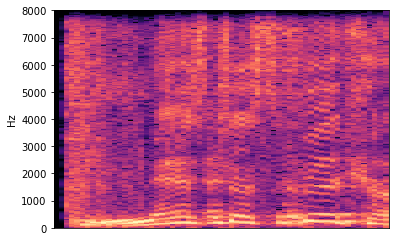

In [15]:
compute_spectrogram_melspectrogram_and_plot(data_dir + "Nelson_Mandela/" + nelson_madela[0], "spectrogram")

C:\Users\laadouz\Anaconda3\envs\tensorflow-session\lib\site-packages\librosa\filters.py:196: FutureWarning: norm=1 behavior will change in librosa 0.8.0. To maintain forward compatibility, use norm='slaney' instead.
  FutureWarning)


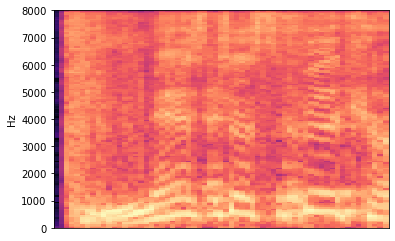

In [16]:
compute_spectrogram_melspectrogram_and_plot(data_dir + "Nelson_Mandela/" + nelson_madela[0], "melspectrogram")

# Process training dataset

In [17]:
# get wav paths
def get_wav_paths(speaker):
    speaker_path = data_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [18]:
nelson_mandela_paths = get_wav_paths("Nelson_Mandela")
margaret_thatcher_paths = get_wav_paths("Magaret_Tarcher")
benjamin_netanyau_paths = get_wav_paths("Benjamin_Netanyau")
jens_stoltenberg_paths = get_wav_paths( 'Jens_Stoltenberg')
julia_gillard_paths = get_wav_paths("Julia_Gillard")

In [19]:
# load the data
def load_wav(wav_path, speaker):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_path = data_dir +speaker + "/"+ wav_path
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
            wav_decoder, feed_dict={
                wav_filename_placeholder: wav_path
            }).audio.flatten().reshape((1, 16000))
        sess.close()
    return wav_data
    

In [20]:
# create training data
def generate_training_data(speaker_paths, speaker, label):
    wavs, labels = [], []
    for i in tqdm(speaker_paths):
        wav = load_wav(i, speaker)
        wavs.append(wav)
        labels.append(label)
    return wavs, labels

In [21]:
nelson_mandela_wavs, nelson_mandela_labels = generate_training_data(nelson_mandela_paths, "Nelson_Mandela", 0) 
margaret_thatcher_wavs, margaret_thatcher_labels = generate_training_data(margaret_thatcher_paths, "Magaret_Tarcher", 1) 
benjamin_netanyau_wavs, benjamin_netanyau_labels = generate_training_data(benjamin_netanyau_paths, "Benjamin_Netanyau", 2) 
jens_stoltenberg_wavs, jens_stoltenberg_labels = generate_training_data(jens_stoltenberg_paths, "Jens_Stoltenberg", 3) 
julia_gillard_wavs, julia_gillard_labels = generate_training_data(julia_gillard_paths, "Julia_Gillard", 4) 

100%|█████████████████████████████████████████████████████████████████████████████| 1501/1501 [00:14<00:00, 101.01it/s]


In [22]:
# remove the extra wav for Julia Gillard
julia_gillard_labels = julia_gillard_labels[1:]
julia_gillard_wavs = julia_gillard_wavs[1:]

In [23]:
all_wavs = nelson_mandela_wavs + margaret_thatcher_wavs + benjamin_netanyau_wavs + jens_stoltenberg_wavs + julia_gillard_wavs
all_labels = nelson_mandela_labels + margaret_thatcher_labels + benjamin_netanyau_labels + jens_stoltenberg_labels + julia_gillard_labels

In [24]:
# split the dataset into trainin and testing set\
train_wavs, test_wavs, train_labels, test_labels = train_test_split(all_wavs, all_labels, test_size=0.2)

In [25]:
train_x, train_y = np.array(train_wavs), np.array(train_labels)
test_x, test_y = np.array(test_wavs), np.array(test_labels)

In [26]:
train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)

# Create a simple model

In [27]:
# create a model
def create_model(speech_feature):
    model = tf.keras.Sequential()
    if speech_feature == "spectrogram":
        model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=(1, 16000),
                            return_decibel_spectrogram=True, power_spectrogram=2.0,
                            trainable_kernel=False, name='static_stft'))
    elif speech_feature == "melspectrogram":
        model.add(Melspectrogram(sr=16000, n_mels=128,n_dft=512, n_hop=256,
                            input_shape=(1 , 16000),return_decibel_melgram=True,
                            trainable_kernel=False, name='melgram'))
   

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4)
            , loss = "categorical_crossentropy"
            , metrics = ["accuracy"])
    return model

In [28]:
# spectrogam model
model = create_model("spectrogram")

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
static_stft (Spectrogram)    (None, 257, 63, 1)        263168    
_________________________________________________________________
conv2d (Conv2D)              (None, 255, 61, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 30, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 243840)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1219205   
Total params: 1,483,013
Trainable params: 1,483,013
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(x=train_x, y=train_y, epochs=10, validation_data=(test_x, test_y))

Train on 6000 samples, validate on 1500 samples
Epoch 1/10
6000/6000 [==============================] - 156s 26ms/sample - loss: 24.0229 - accuracy: 0.6438 - val_loss: 0.5162 - val_accuracy: 0.8713
Epoch 2/10
6000/6000 [==============================] - 141s 24ms/sample - loss: 0.6286 - accuracy: 0.8805 - val_loss: 2.4880 - val_accuracy: 0.7020
Epoch 3/10
6000/6000 [==============================] - 141s 23ms/sample - loss: 0.3996 - accuracy: 0.9257 - val_loss: 0.3561 - val_accuracy: 0.9347
Epoch 4/10
6000/6000 [==============================] - 141s 24ms/sample - loss: 0.0334 - accuracy: 0.9878 - val_loss: 0.2571 - val_accuracy: 0.9400
Epoch 5/10
6000/6000 [==============================] - 145s 24ms/sample - loss: 0.0079 - accuracy: 0.9977 - val_loss: 0.2758 - val_accuracy: 0.9367
Epoch 6/10
6000/6000 [==============================] - 141s 23ms/sample - loss: 3.6460e-04 - accuracy: 1.0000 - val_loss: 0.2044 - val_accuracy: 0.9533
Epoch 7/10
6000/6000 [==============================]

In [32]:
# melspectrogram model
model = create_model("melspectrogram")

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melgram (Melspectrogram)     (None, 128, 63, 1)        296064    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 61, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 120960)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 604805    
Total params: 901,509
Trainable params: 901,509
Non-trainable params: 0
_________________________________________________________________


In [31]:
# melspectrogram model
model = model.save("speakers.h5")

In [34]:
model.fit(x=train_x, y=train_y, epochs=10, validation_data=(test_x, test_y))

Train on 6000 samples, validate on 1500 samples
Epoch 1/10
6000/6000 [==============================] - 84s 14ms/sample - loss: 15.8462 - accuracy: 0.5808 - val_loss: 6.4417 - val_accuracy: 0.6153
Epoch 2/10
6000/6000 [==============================] - 86s 14ms/sample - loss: 2.3980 - accuracy: 0.7793 - val_loss: 2.5840 - val_accuracy: 0.7653
Epoch 3/10
6000/6000 [==============================] - 117s 19ms/sample - loss: 1.2105 - accuracy: 0.8508 - val_loss: 3.1405 - val_accuracy: 0.6913
Epoch 4/10
6000/6000 [==============================] - 92s 15ms/sample - loss: 1.0868 - accuracy: 0.8527 - val_loss: 1.2359 - val_accuracy: 0.8413
Epoch 5/10
6000/6000 [==============================] - 89s 15ms/sample - loss: 0.9216 - accuracy: 0.8595 - val_loss: 0.9784 - val_accuracy: 0.8333
Epoch 6/10
6000/6000 [==============================] - 94s 16ms/sample - loss: 0.4168 - accuracy: 0.9147 - val_loss: 0.6787 - val_accuracy: 0.8800
Epoch 7/10
6000/6000 [==============================] - 81s 14

In [35]:
# melspectrogram model
model = model.save("speakers5.h5")